In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as stats
import numpy as np
import pickle

# GCP

In [2]:
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5])
df.head()

,ocean sink,land sink
Year,,
1959,0.852376,0.516073
1960,0.819017,1.394030
1961,0.714842,0.605098
1962,0.756709,1.348349
1963,0.904997,0.877794


In [3]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [4]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df.head()

,ocean sink,land sink,CO2
Year,,,
1959,-0.852376,-0.516073,315.486
1960,-0.819017,-1.394030,316.163
1961,-0.714842,-0.605098,316.856
1962,-0.756709,-1.348349,317.558
1963,-0.904997,-0.877794,318.268


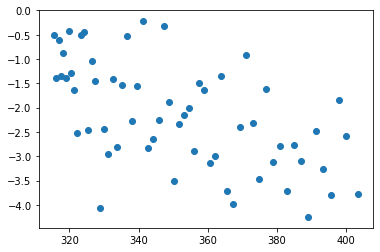

In [5]:
plt.scatter(df.CO2, df['land sink'])

In [17]:
next_val = CO2.values.squeeze()[0]+20

indices= []
for index, val in enumerate(CO2.values.squeeze()):
    if val > next_val:
        indices.append(index)
        next_val = CO2.values.squeeze()[index]+20
indices

[21, 35, 47, 57]

In [18]:
CO2.iloc[indices]

,CO2
Year,
1980,336.732
1994,357.527
2006,378.887
2016,400.130


In [35]:
def co2_window(ds, window=20):
    next_val = ds.values.squeeze()[0]+window
    
    indices = [0]
    for index, val in enumerate(CO2.values.squeeze()):
        if val > next_val:
            indices.append(index)
            next_val = CO2.values.squeeze()[index]+window
    
    return indices

In [36]:
co2_window(CO2, 10)

[0, 13, 21, 28, 35, 42, 48, 53, 58]

In [37]:
df.head()

,ocean sink,land sink,CO2
Year,,,
1959,-0.852376,-0.516073,315.486
1960,-0.819017,-1.394030,316.163
1961,-0.714842,-0.605098,316.856
1962,-0.756709,-1.348349,317.558
1963,-0.904997,-0.877794,318.268


In [52]:
first, second = co2_window(df.CO2, window=20)[0], co2_window(df.CO2, window=20)[1]
ds = df.iloc[first:second+1]
stats.linregress(ds.CO2, ds['land sink'])[0]

-0.05793202336221356

In [63]:
def rolling_trend_co2(data, sink='land sink', window=20, r_plot=False):
    
    def co2_window(ds, window):
        next_val = ds.values.squeeze()[0]+window

        indices = [0]
        for index, val in enumerate(CO2.values.squeeze()):
            if val > next_val:
                indices.append(index)
                next_val = CO2.values.squeeze()[index]+window

        return indices
    
    roll_values = []
    r_values = []
    
    for i in co2_window(data.CO2, window):
        df = data.iloc[i:i+1]
        roll_values.append(stats.linregress(df.CO2, df[sink])[0])
        r_values.append(stats.linregress(df.CO2, df[sink])[2])
        
    plt.plot(data.CO2, data[sink])
    roll_df = pd.DataFrame({f'{window}-CO2 trend slope': roll_values}, index=data.CO2[:-window])
    roll_df.plot(color='g')
    
    if r_plot:
        r_df = pd.DataFrame({'r-values of trends': r_values}, index=data.index[:-window])
        r_df.plot(color='k')
        return roll_df, r_df
    
    return roll_df

ValueError: Shape of passed values is (5, 1), indices imply (39, 1)

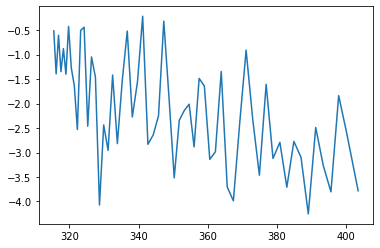

In [64]:
land_roll_co2 = rolling_trend_co2(df)
land_roll_co2

In [98]:
stats.linregress(land_roll_co2.index, land_roll_co2.values.squeeze())

LinregressResult(slope=0.00010840784535201978, intercept=-0.0595002545331424, rvalue=0.08131315084167529, pvalue=0.622652079461566, stderr=0.00021845327143765376)

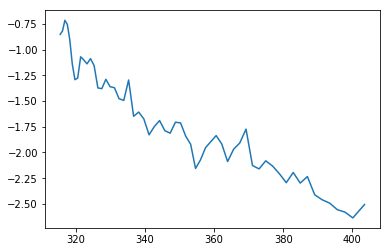

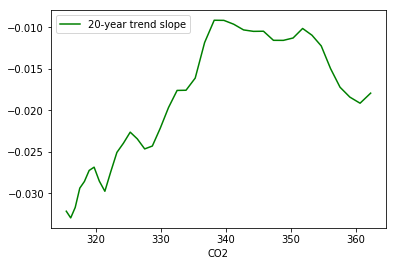

In [101]:
ocean_roll_co2 = rolling_trend_co2(df, sink='ocean sink')

In [103]:
stats.linregress(ocean_roll_co2.index, ocean_roll_co2.values.squeeze())

LinregressResult(slope=0.00041160739060289273, intercept=-0.15765778837938008, rvalue=0.7824786727332868, pvalue=4.002829745771076e-09, stderr=5.3848410246486505e-05)